# Main

___
## Imports

In [1]:
import numpy as np
import os
import cv2
import json
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

from utils.load import download_flickr, download_glove, load_data, load_split_dataset
from utils.explore import (
    get_descriptive_statistics,
    explore_dataset,
    visualize_image,
    get_captions,
)
from utils.split import split_and_save_data
from utils.preprocessing import get_vocabulary, resize_image_dictionary, pad_images

import tensorflow as tf
from keras.applications.inception_v3 import (
    InceptionV3,
    preprocess_input,
    decode_predictions,
)
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Input, Dropout, Dense, Embedding, LSTM, MaxPooling2D, Conv2D, add

from utils.model import ImageCaptioningModel

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset



c:\Users\justi\Desktop\CS\Cours\3A\deep-learning\image-caption-generator\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


___
## Global Variables

In [2]:
image_folder = "data/Images"
image_folder_homogeneous = "data/Images_homogeneous"
captions_file = "data/captions.txt"
split_data = "data/split_dataset"

___
## Downloading the Dataset

If not already done

In [3]:
if not os.path.exists("data/Images"):
    download_flickr()

___
## Exploring the Dataset

Valid if the dataset has already been loaded into your `data` folder.

Number of images: 8091
Max width: 500, Min width: 164, Mean width: 457.87220368310466
Max height: 500, Min height: 127, Mean height: 397.25188481028306


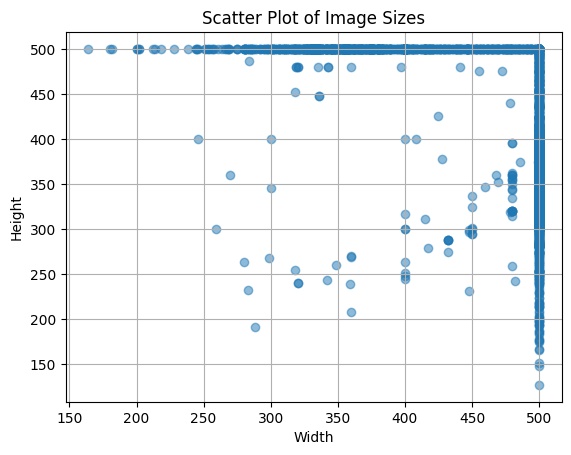

In [4]:
get_descriptive_statistics(image_folder)

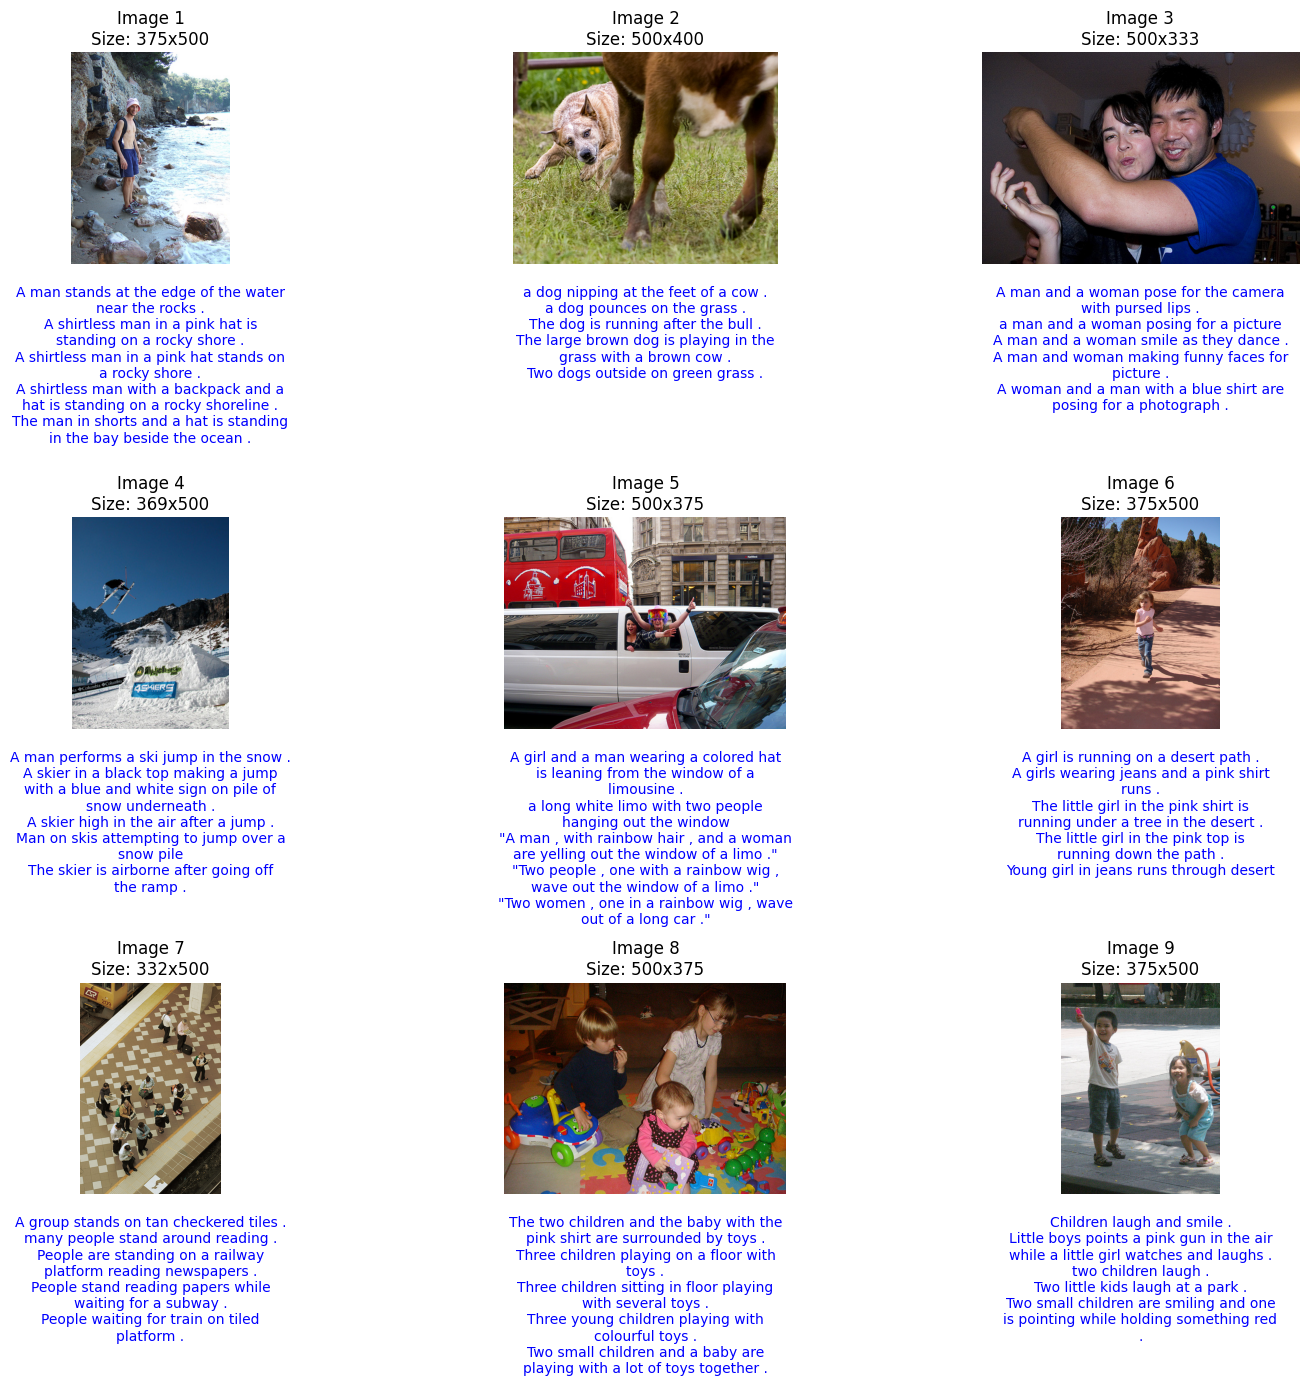

In [5]:
explore_dataset(image_folder, captions_file)

We notice that the dataset is very diverse. Especially, the image sizes are not homogeneous. We need to standardize them to make them fit in a neural network. Since the images seem to all have either a width or a height of 500 pixels, we choose to pad them, adding black pixels, so that they have all the same shape of $500 \times 500$ pixels.

___
## Loading the Data

In [6]:
# adding padding so that all images have the same dimensions
if not os.path.exists(image_folder_homogeneous):
    pad_images(image_folder, image_folder_homogeneous, target_size=(500, 500))

In [7]:
# loading the homogeneous dataset
image_arrays, image_captions = load_data(image_folder_homogeneous, captions_file)

### Cleaning the Captions

We exploring the `data/captions.txt` file, we notice that the captions seem to end with a `.`, so let's just remove this to have cleaner captions.

In [8]:
image_captions = {
    img_name: [cap.replace('.', '').strip().lower() for cap in captions]
    for img_name, captions in image_captions.items()
}

### Creating the Vocabulary

The vocabulary contains all the unique words present in the captions.

In [9]:
vocabulary = get_vocabulary(image_captions)

___
## Splitting the Dataset

This is important to train the model on a dataset and then be able to test it on a new dataset it hasn't seen before.

In [10]:
train_data, test_data, train_captions, test_captions = split_and_save_data(image_arrays, image_captions, save_folderpath=split_data)

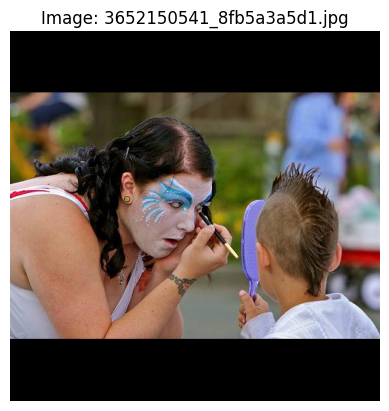

['a woman applies face paint while a boy with a mohawk holds a mirror', 'a woman painting her face while a child with a mohawk holds a mirror', 'a woman painting on makeup', 'a woman paints her face while a boy with a mohawk holds her mirror', 'child with mohawk haircut holding mirror for woman putting on face paint']


In [11]:
i = 128
visualize_image(train_data, i)
print(
    get_captions(train_captions, i)
)

___
## Extracting a Feature Vector from each image

We can extract the main features of an image with a pre-trained model, which has been trained in a large dataset. This way we can get from each image a vector containing the main characteristics of this image. We will use the **InceptionV3** model.

In [12]:
def get_ith_value(dict, i):
    return list(dict.values())[i]

In [13]:
recompute = False
feature_vectors_path = 'data/feature_vectors.json'

if not os.path.exists(feature_vectors_path) or recompute:

    base_model = InceptionV3(weights="imagenet")
    model = Model(base_model.input, base_model.layers[-2].output)


    def encode_images(
        img_dict: dict, model: Model = model, batch_size: int = 32
    ) -> dict[str, np.ndarray]:
        print("resizing the images...")
        resized_images = resize_image_dictionary(img_dict, (299, 299))
        feature_vectors = {}
        print("extracting the feature vectors...")
        img_names = list(resized_images.keys())
        img_arrays = list(resized_images.values())
        # preprocessing all images
        img_arrays = [preprocess_input(img_array) for img_array in img_arrays]

        batch_number = 0
        for start_index in range(0, len(img_names), batch_size):
            if batch_number % 10 == 0:
                print(f"batch number {batch_number}")
            end_index = min(start_index + batch_size, len(img_names))
            batch_images = img_arrays[start_index:end_index]
            batch_names = img_names[start_index:end_index]
            # predicting the feature vectors for the batch
            batch_vectors = model.predict(np.array(batch_images))
            # reshaping and storing the feature vectors
            for i, img_name in enumerate(batch_names):
                vec = np.reshape(batch_vectors[i], (batch_vectors.shape[1]))
                feature_vectors[img_name] = vec
            batch_number += 1
            
        return feature_vectors


    img_characteristics = encode_images(train_data)

    print(img_characteristics)
    print(len(list(train_data.values())), len(img_characteristics.values()))

    # saving the dictionary as a JSON file to avoid the computation time later
    with open(feature_vectors_path, 'w') as json_file:
        serializable_dict = {k: [float(elt) for elt in list(v)] for k,v in img_characteristics.items()}
        json.dump(serializable_dict, json_file, indent=4)
    print(f"Dictionary has been stored as JSON in {feature_vectors_path}")
else:
    # loading the dictionary from a JSON file
    print(f"loading from {feature_vectors_path}")
    with open(feature_vectors_path, 'r', encoding='utf-8') as json_file:
        json_dict = json.load(json_file)
        img_characteristics = {k:np.array(v, dtype=np.float32) for k,v in json_dict.items()}
    print("File loaded successfully")
    print(img_characteristics)

loading from data/feature_vectors.json
File loaded successfully
{'2715289538_d77c8d0a85.jpg': array([0.19931675, 0.8567636 , 0.37497547, ..., 0.7677796 , 1.9258292 ,
       0.07857573], dtype=float32), '905355838_3a43fdfd4e.jpg': array([0.10892228, 0.12032688, 0.22689062, ..., 0.11779635, 0.18027431,
       0.4529422 ], dtype=float32), '2378356400_f6bde5d9b3.jpg': array([0.50352764, 0.94646144, 1.0422158 , ..., 0.06111301, 0.14224978,
       0.19829868], dtype=float32), '2985679744_75a7102aab.jpg': array([0.4813395 , 0.24327543, 0.64928263, ..., 0.0093038 , 0.        ,
       0.38532364], dtype=float32), '2926595608_69b22be8d4.jpg': array([0.30628872, 0.21017288, 0.27170324, ..., 0.4027413 , 0.18206644,
       0.2836861 ], dtype=float32), '2252403744_148fc11f68.jpg': array([0.40105787, 0.26674077, 0.39530626, ..., 0.18654886, 0.14945483,
       0.23881704], dtype=float32), '2860667542_95abec3380.jpg': array([0.09831312, 0.02977256, 0.36271244, ..., 0.30082572, 0.25359112,
       0.2706

___
## Tokenization of the Vocabulary

We need to tokenize our vocabulary to make it understandable for a neural network.

In [14]:
min_apparitions = 10  # defining a threshold of number of apparitions in the text.

text = " ".join(
    [" ".join(train_captions[img_name]) for img_name in list(train_captions.keys())]
)
# doit-on mettre les 3 dict captions ou non ?

words = text.split(" ")

# this returns a dictionary containing the words and the number of their occurrences in the text
words_count = Counter(words)

# keeping just the important words
important_words = [
    word for word, n_occ in words_count.items() if n_occ >= min_apparitions
]

# mapping the words to integers
int_to_word = {i: word for i, word in enumerate(important_words)}
word_to_int = {word: i for i, word in enumerate(important_words)}

vocabulary_size = len(list(int_to_word.keys()))
print(vocabulary_size)

# find the maximum length of a description in a dataset
max_length = max(
    [
        max([len(caption.split(" ")) for caption in captions])
        for captions in list(train_captions.values())
    ]
)
print(max_length)

1872
37


___
## Vector Embeddings

In [15]:
if not os.path.exists("data/glove"):
    download_glove()

In [16]:
# resizing for computation
target_size = (299, 299)
train_data = resize_image_dictionary(train_data, target_size)
test_data = resize_image_dictionary(test_data, target_size)

In [17]:
X1, X2, y = [], [], []

for img_name, caps in train_captions.items():
    img_features = img_characteristics[img_name]

    for cap in caps:
        sequence = [word_to_int[word] for word in cap.split(" ") if word in word_to_int]

        for i in range(1, len(sequence)):
            input_sequence = sequence[:i]
            output_sequence = sequence[i]

            input_sequence = pad_sequences([input_sequence], maxlen=max_length)[0]
            output_sequence = to_categorical(
                [output_sequence], num_classes=vocabulary_size
            )[0]

            X1.append(img_features)
            X2.append(input_sequence)
            y.append(output_sequence)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)


# load glove vectors for embedding layer
embeddings_index = {}
glove_path = "data/glove/glove.6B.200d.txt"
glove = open(glove_path, "r", encoding="utf-8").read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
    if word != '':
        indices = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = indices




In [18]:
print(type(X1), X1.dtype, X1.shape)
print(X1[0])

<class 'numpy.ndarray'> float32 (344199, 2048)
[0.19931675 0.8567636  0.37497547 ... 0.7677796  1.9258292  0.07857573]


In [19]:
embedding_dim = 200
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
print(embedding_matrix.shape)
for word, i in word_to_int.items():
    if word != '' and word in embeddings_index:
        embedding_vector = embeddings_index[word]
        if embedding_vector is not None and embedding_vector.shape != (0,):
            embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1872, 200)


(1872, 200)

___
## Defining the Model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda


In [21]:
model = ImageCaptioningModel(target_size, vocabulary_size, embedding_dim, device)
model = model.to(device) # making sure it's on the device

___
## Training the Model

In [22]:
batch_size = 128

In [23]:
# Set the weights of the embedding layer
# embedding_matrix = np.random.rand(vocabulary_size, embedding_dim)  # Example embedding matrix
embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)
model.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32).to(device))
model.embedding.weight.requires_grad = False  # Freeze the embedding layer

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [24]:
# Data generator
class CustomDataset(Dataset):
    def __init__(self, X1, X2, y):
        self.X1 = X1
        self.X2 = X2
        self.y = y

    def __len__(self):
        return len(self.X1)

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

In [25]:

dataset = CustomDataset(X1, X2, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# modifying one layer (to not have to rerun the whole file)
# model.fc1 = nn.Linear(2048, 256).to(device)

# Training loop
num_epochs = 50
model.train() # set the model to training mode
print("device:", model.device)

for epoch in range(num_epochs):
    for batch_idx, (x1_batch, x2_batch, y_batch) in enumerate(train_loader):
        x1_batch = x1_batch.clone().detach().to(torch.float32).to(device)
        # if x1_batch.shape[1] != 3: # if the channel is at last index 
        #     x1_batch = x1_batch.permute(0, 3, 1, 2) # it should be
        x2_batch = x2_batch.clone().detach().to(torch.long).to(device)
        y_batch = y_batch.clone().detach().to(torch.float32).to(device)

        # print(x1_batch.device, x2_batch.device, y_batch.device)
        # print(x1_batch.shape, x2_batch.shape)
        optimizer.zero_grad()
        outputs = model(x1_batch, x2_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'\rEpoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}', end='')

print("\nTraining completed.")

device: cuda
Epoch [100/100], Batch [2681/2690], Loss: 1.8109
Training completed.


In [26]:
model_path = "model_2.pth"
if os.path.exists(model_path):
    user_input = input(
        f"{model_path} already exists. Do you want to overwrite it? (yes/no): "
    )
    if user_input.lower() == "yes":
        torch.save(model.state_dict(), 'model_2.pth')
        print(f"The model {model_path} has been overwritten successfully.")
    else:
        print("Saving cancelled.")



___
## Generating Captions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1, 2048)


C:\Users\justi\AppData\Local\Temp\ipykernel_20516\2469766876.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_vector = torch.tensor(feature_vector, dtype=torch.float32).to(device)


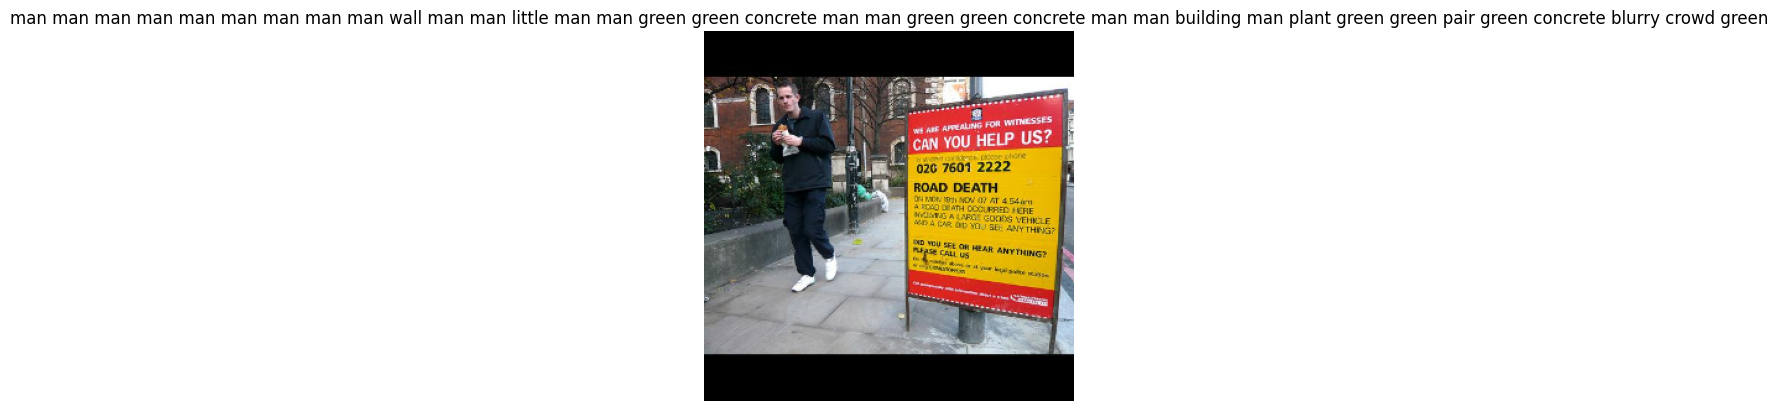

Prediction:
man man man man man man man man man wall man man little man man green green concrete man man green green concrete man man building man plant green green pair green concrete blurry crowd green
Reference Captions:
a man dressed in black and holding a package in his hands is walking on a sidewalk near a police sign asking for witnesses to a road dealth to step forward
a man in black walking past a red and yellow signpost whilst eating
a man is eating and walking past a yellow and red sign
a man is eating something and walking down a sidewalk past a big red and yellow sign
a sign asking for help with a man walking by eating


'man man man man man man man man man wall man man little man man green green concrete man man green green concrete man man building man plant green green pair green concrete blurry crowd green'

In [27]:
## Predict output


def get_image_array(img_dict: dict[str, np.array], idx: int) -> np.array:
    return list(img_dict.values())[idx]

def get_captions_list(captions_dict:dict[str, list[str]],idx:int)->list[str]:
    return list(captions_dict.values())[idx]

def generate_caption(img_index:int,show:bool=True):
    model.eval() # setting the model to evaluation mode
    img_array = get_image_array(test_data, img_index)# getting the image array
    # print("img_array.shape", img_array.shape)
    img_resized = np.array([preprocess_input(cv2.resize(img_array, (299, 299)))])
    # print("img_resized.shape", img_resized.shape)
    # extracting feature vector
    base_model = InceptionV3(weights="imagenet")
    feature_extraction_model = Model(base_model.input, base_model.layers[-2].output)
    feature_vector = feature_extraction_model.predict(img_resized)
    print(feature_vector.shape)
    # setting up the input sequence
    start = "startseq"
    sequence = [word_to_int[word] for word in start.split() if word in word_to_int]

    with torch.no_grad():  # Disable gradient calculation for inference
        for i in range(max_length):
            # Convert image_array to a tensor and move to the correct device
            feature_vector = torch.tensor(feature_vector, dtype=torch.float32).to(device)

            # Convert sequence to a tensor, pad it, and move to the correct device
            input_sequence = pad_sequences([sequence], maxlen=max_length, padding='post')[0]
            sequence_tensor = torch.tensor(input_sequence, dtype=torch.long).unsqueeze(0).to(device)

            # Ensure the sequence length is greater than 0
            if sequence_tensor.size(1) == 0:
                raise ValueError("Sequence length is 0. Ensure the sequence is properly initialized.")

            # print(feature_vector.shape, sequence_tensor.shape)

            # Get model prediction
            y_pred = model(feature_vector, sequence_tensor)
            y_pred = y_pred.argmax(dim=-1).item()

            word = int_to_word[y_pred]
            start += ' ' + word
            sequence.append(y_pred)

            if word == "endseq":
                break

    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)

    reference_captions = get_captions_list(test_captions, img_index)

    if show:
        # Display the image and the caption
        plt.imshow(img_array)
        plt.title(final)
        plt.axis('off')  # Hide the axis
        plt.show()

        print("Prediction:")
        print(final)
        print("Reference Captions:")
        print('\n'.join(reference_captions))
    
    return final


img_index = 128
generate_caption(img_index)